# Preprocess

In [1]:
import os

import numpy as np
import pandas as pd
import cudf
import matplotlib.pyplot as plt

import gc
import torch

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [3]:
class CFG:
    input_dir = os.path.join("/kaggle", "input")
    output_dir = os.path.join("/kaggle", "working")
    competition_dir = os.path.join(input_dir, "child-mind-institute-detect-sleep-states")
    train_series = os.path.join(competition_dir, "train_series.parquet")
    train_event = os.path.join(competition_dir, "train_events.csv")

    comp_train_series = os.path.join(input_dir, "comp_train_series.parquet")
    comp_train_event = os.path.join(input_dir, "comp_train_event.parquet")

    test_series = os.path.join(competition_dir, "test_series.parquet")
    sample_sub = os.path.join(competition_dir, "sample_submission.csv")

In [4]:
# train_series = pd.read_parquet(CFG.comp_train_series)
train_series = pd.read_parquet(CFG.train_series)
len(train_series)
original_data_num = len(train_series)

In [5]:
train_series.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [6]:
train_series.tail()

,series_id,step,timestamp,anglez,enmo
127946335,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204
127946336,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233
127946337,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202
127946338,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199
127946339,fe90110788d2,592379,2017-09-08T00:14:55-0400,-31.521601,0.0205


In [7]:
# train_event = pd.read_parquet(CFG.comp_train_event)
train_event = pd.read_csv(CFG.train_event)

In [8]:
train_event.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [9]:
train_event.tail()

,series_id,night,event,step,timestamp
14505,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14506,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14507,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14508,fe90110788d2,35,onset,NaN,NaN
14509,fe90110788d2,35,wakeup,NaN,NaN


In [10]:
train_event.isnull().sum()

series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64

In [11]:
# stepがnullのデータのうちeventがonsetのものをunknown_onsetに変更する
train_event.loc[(train_event["step"].isnull()) & (train_event["event"] == "onset"), "event"] = "unknown_onset"
train_event.loc[(train_event["step"].isnull()) & (train_event["event"] == "wakeup"), "event"] = "unknown_wakeup"

In [12]:
# event がunknown_onsetのときのstepは一つ前のデータのstep+1とする
train_event.loc[train_event["event"] == "unknown_onset", "step"] = train_event["step"].shift(1) + 1
# event がunknown_wakeupのときのstepは一つ後のデータのstep-1とする
train_event.loc[train_event["event"] == "unknown_wakeup", "step"] = train_event["step"].shift(-1) - 1

In [13]:
len(train_event["series_id"].unique())

277

# series_id全体がNaNのデータを削除する

In [14]:
# # series_idでgroupbyしてstepが全てnullのデータを抽出する
# null_step = train_event[train_event["step"].isnull()].groupby("series_id").count().reset_index()
# print(len(null_step["series_id"].unique()))

In [15]:
# series_idでgroupbyしてstepに一つでもnullがあるデータを抽出する
null_step = train_event[(train_event["step"].isnull()) | (train_event["timestamp"].isnull())].groupby("series_id").count().reset_index()
print(len(null_step["series_id"].unique()))

240


In [16]:
non_null_event = train_event[~train_event["series_id"].isin(null_step["series_id"])]
non_null_event.isnull().sum()

series_id    0
night        0
event        0
step         0
timestamp    0
dtype: int64

In [17]:
non_null_series = train_series[~train_series["series_id"].isin(null_step["series_id"])]
non_null_series.isnull().sum()

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64

In [18]:
train_event = train_event[~train_event["series_id"].isin(null_step["series_id"].unique())]
train_series = train_series[~train_series["series_id"].isin(null_step["series_id"].unique())]

# イベントデータのseriesへの統合

In [19]:
def set_train_label(train_series_:pd.DataFrame, train_event_:pd.DataFrame) -> pd.DataFrame:
    train_event_["step"] = train_event_["step"].astype("int32")
    train_event_.loc[(train_event_["step"].isnull()) & (train_event_["event"] == "onset"), "event"] = "unknown_onset"
    train_event_.loc[(train_event_["step"].isnull()) & (train_event_["event"] == "wakeup"), "event"] = "unknown_wakeup"
    # event がunknown_onsetのときのstepは一つ前のデータのstep+1とする
    train_event_.loc[train_event_["event"] == "unknown_onset", "step"] = train_event_["step"].shift(1) + 1
    # event がunknown_wakeupのときのstepは一つ後のデータのstep-1とする
    train_event_.loc[train_event_["event"] == "unknown_wakeup", "step"] = train_event_["step"].shift(-1) - 1

    # eventのonsetを0, wakeupを1, unknown_onsetとunknown_wakeupを2とする
    train_event_["event"] = train_event_["event"].map({"onset":0, "wakeup":1, "unknown_onset":2, "unknown_wakeup":3})

    df = pd.merge(train_series_, train_event_[["series_id","step", "event"]], on=["series_id", "step"], how="left")
    df["event_onset"] = df["event"].apply(lambda x: 1 if x == 0 else 0)
    df["event_wakeup"] = df["event"].apply(lambda x: 1 if x == 1 else 0)
    df = df.bfill(axis="rows")
    return df

In [20]:
def set_train_groupby_label(train_series_:pd.DataFrame, train_event_:pd.DataFrame) -> pd.DataFrame:
    train_event_["step"] = train_event_["step"].astype("int32")
    train_event_.loc[(train_event_["step"].isnull()) & (train_event_["event"] == "onset"), "event"] = "unknown_onset"
    train_event_.loc[(train_event_["step"].isnull()) & (train_event_["event"] == "wakeup"), "event"] = "unknown_wakeup"

    # series_idでgroup_byしてunknown_onsetとunknown_wakeupのstepを補完する
    train_event_["step"] = train_event_.groupby("series_id")["step"].apply(lambda x: x.bfill(axis="rows"))
    train_event_["step"] = train_event_.groupby("series_id")["step"].apply(lambda x: x.ffill(axis="rows"))

    # eventのonsetを0, wakeupを1, unknown_onsetとunknown_wakeupを2とする
    train_event_["event"] = train_event_["event"].map({"onset":0, "wakeup":1, "unknown_onset":2, "unknown_wakeup":3})

    df = pd.merge(train_series_, train_event_[["series_id","step", "event"]], on=["series_id", "step"], how="left")
    df["event_onset"] = df["event"].apply(lambda x: 1 if x == 0 else 0)
    df["event_wakeup"] = df["event"].apply(lambda x: 1 if x == 1 else 0)
    df = df.bfill(axis="rows")
    return df

In [21]:
train_event = train_event.dropna()

In [22]:
# train_series = set_train_label(train_series, train_event)
train_series = set_train_groupby_label(train_series, train_event)

/tmp/ipykernel_4616/4228975711.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  train_event_["step"] = train_event_.groupby("series_id")["step"].apply(lambda x: x.bfill(axis="rows"))
/tmp/ipykernel_4616/4228975711.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  train_event_["step"] = trai

In [23]:
processed_data_num = len(train_series)
print(f"original_data_num: {original_data_num}, processed_data_num: {processed_data_num}, diff: {original_data_num - processed_data_num}")
print(f"percetage: {processed_data_num / original_data_num * 100}%")

original_data_num: 127946340, processed_data_num: 14334840, diff: 113611500
percetage: 11.203790589086019%


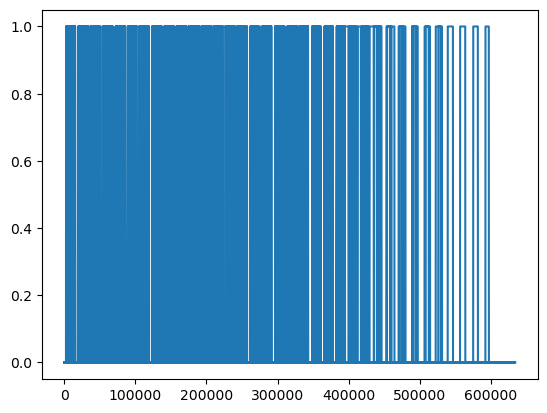

In [24]:
plt.plot(train_series["step"], train_series["event"])

In [25]:
train_series = train_series.dropna()

In [26]:
train_series

,series_id,step,timestamp,anglez,enmo,event,event_onset,event_wakeup
0,08db4255286f,0,2018-11-05T10:00:00-0400,-30.845301,0.0447,0.0,0,0
1,08db4255286f,1,2018-11-05T10:00:05-0400,-34.181801,0.0443,0.0,0,0
2,08db4255286f,2,2018-11-05T10:00:10-0400,-33.877102,0.0483,0.0,0,0
3,08db4255286f,3,2018-11-05T10:00:15-0400,-34.282101,0.0680,0.0,0,0
4,08db4255286f,4,2018-11-05T10:00:20-0400,-34.385799,0.0768,0.0,0,0
...,...,...,...,...,...,...,...,...
14329112,d5e47b94477e,390092,2017-12-02T07:47:40-0500,23.911301,0.0000,1.0,0,0
14329113,d5e47b94477e,390093,2017-12-02T07:47:45-0500,23.911301,0.0000,1.0,0,0
14329114,d5e47b94477e,390094,2017-12-02T07:47:50-0500,23.880699,0.0000,1.0,0,0
14329115,d5e47b94477e,390095,2017-12-02T07:47:55-0500,23.940100,0.0000,1.0,0,0


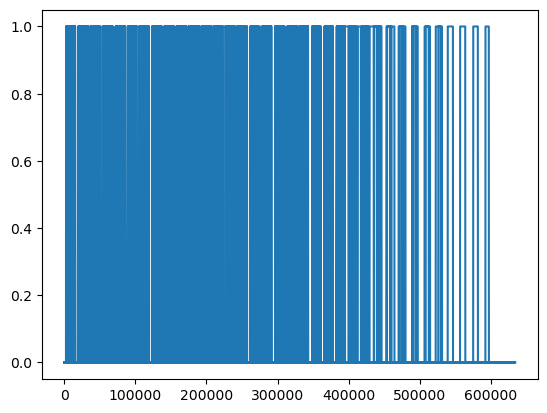

In [27]:
plt.plot(train_series["step"], train_series["event"])

08db4255286f


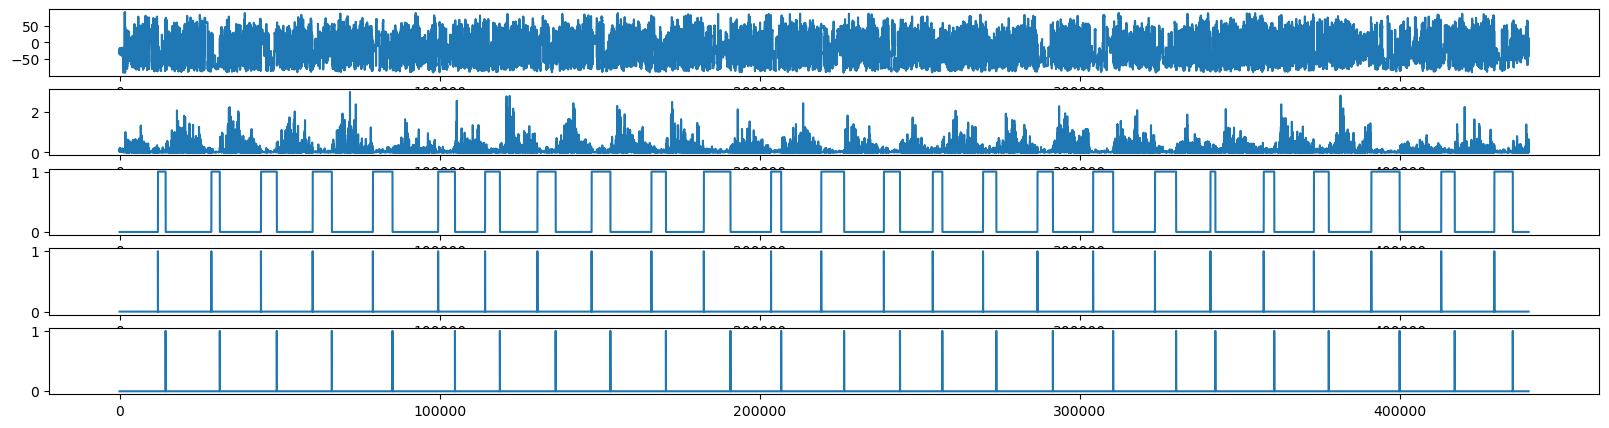

0a96f4993bd7


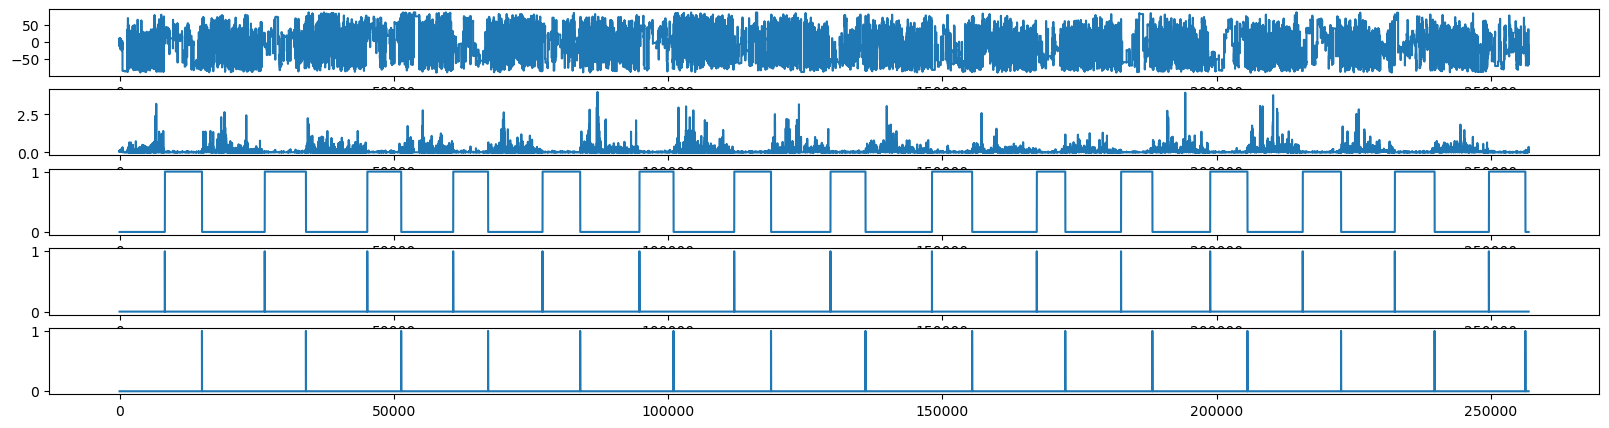

0cfc06c129cc


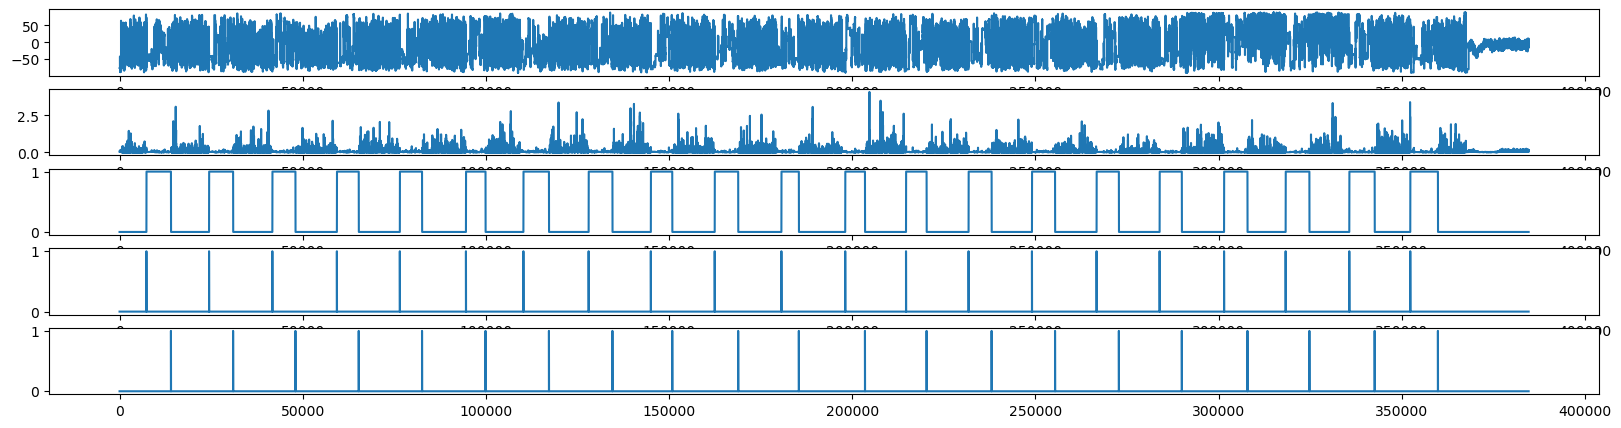

1087d7b0ff2e


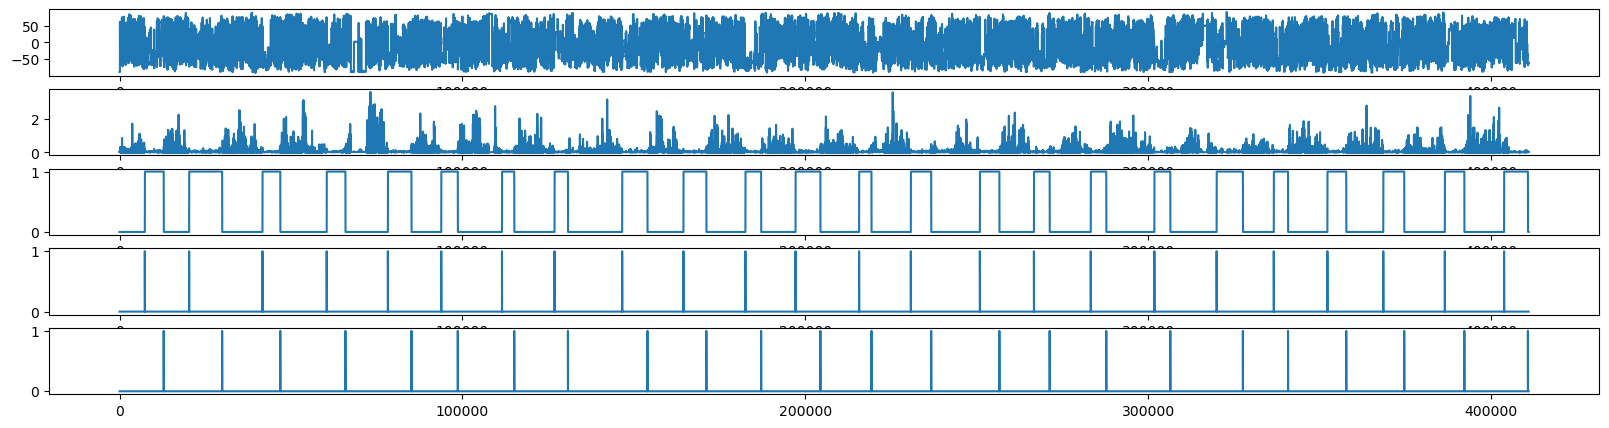

10f8bc1f7b07


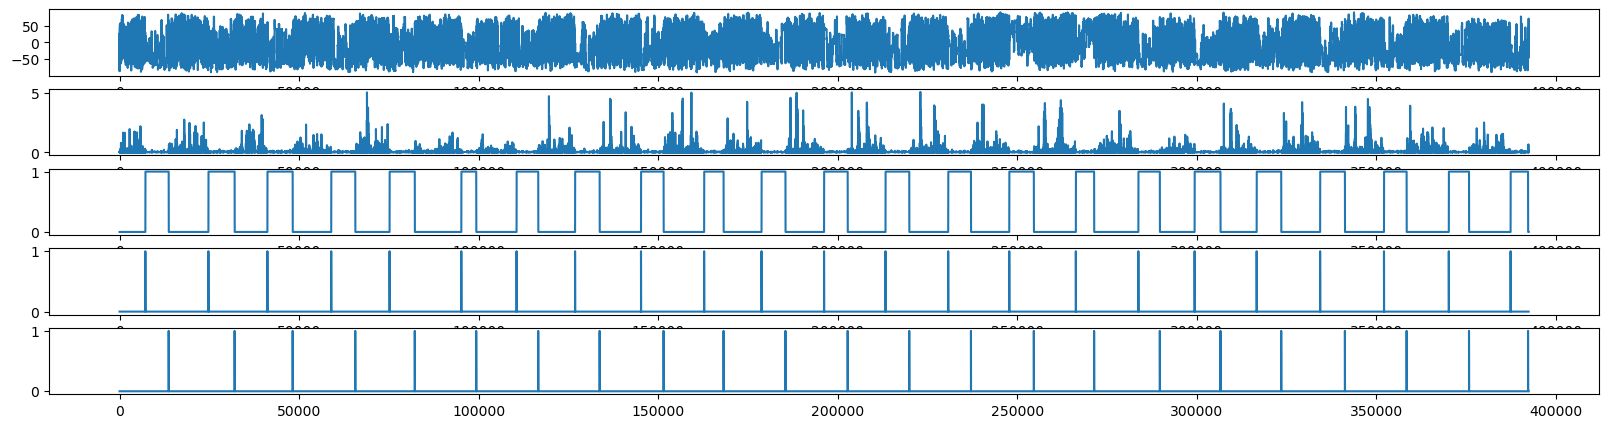

18b61dd5aae8


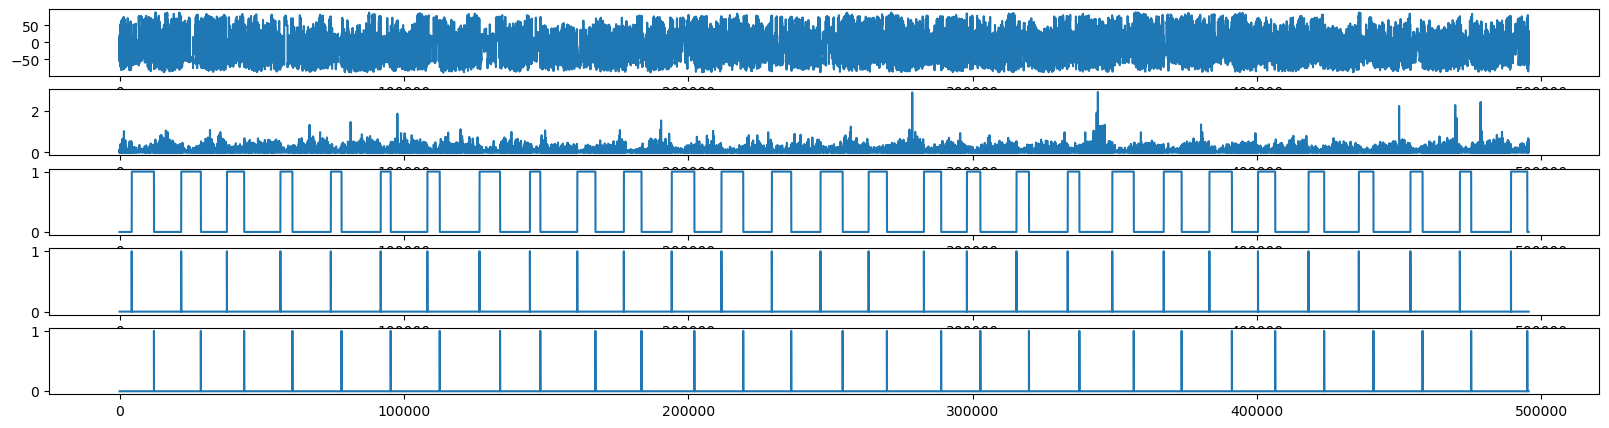

29c75c018220


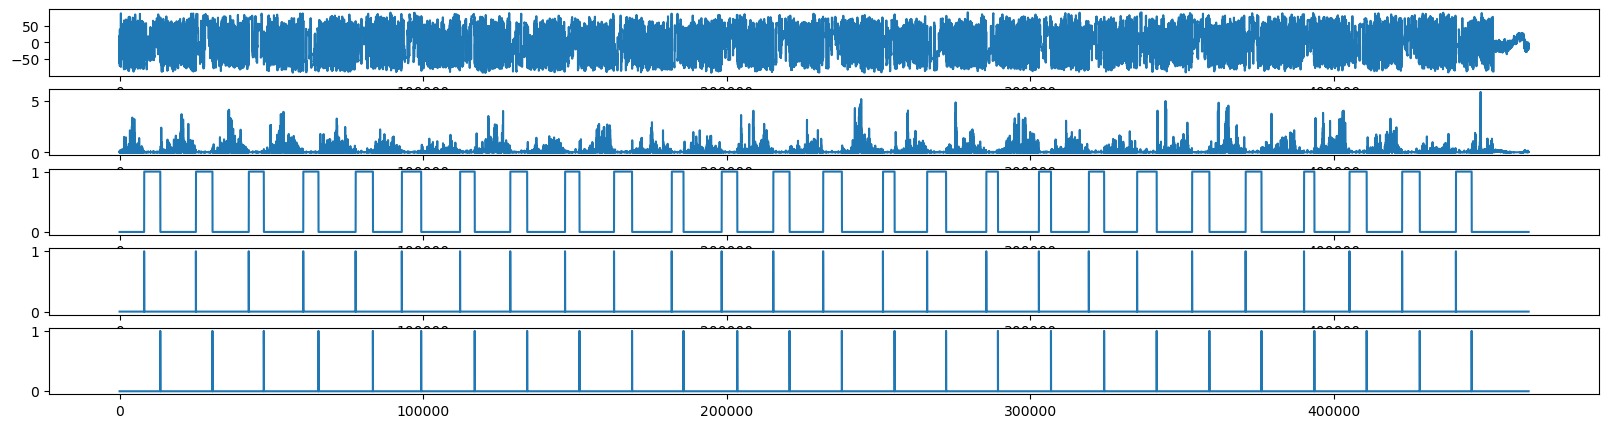

31011ade7c0a


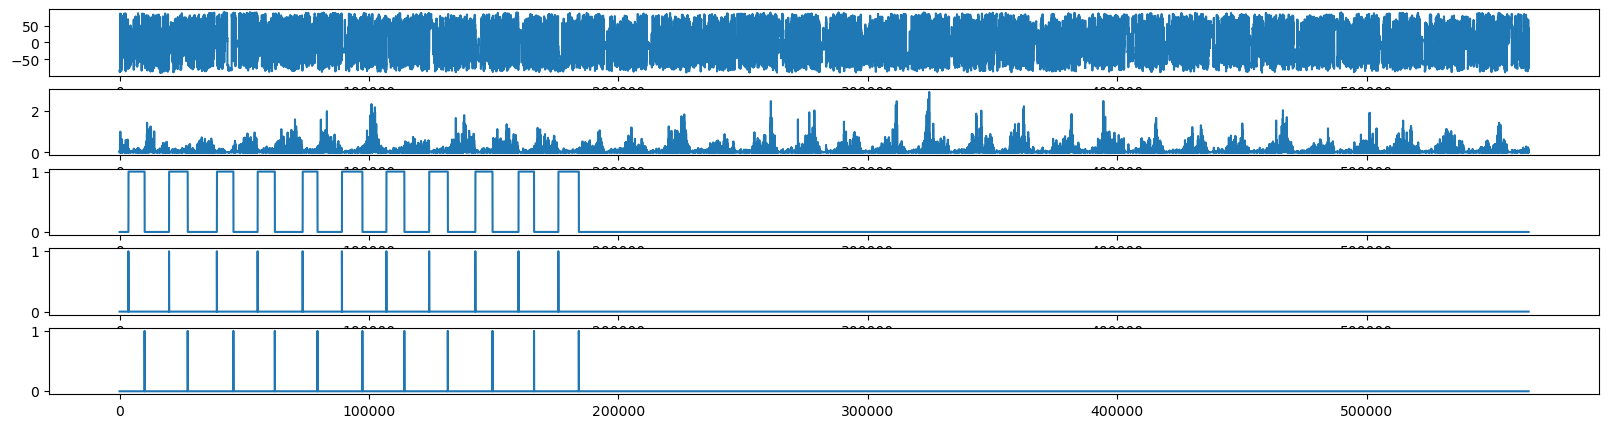

3452b878e596


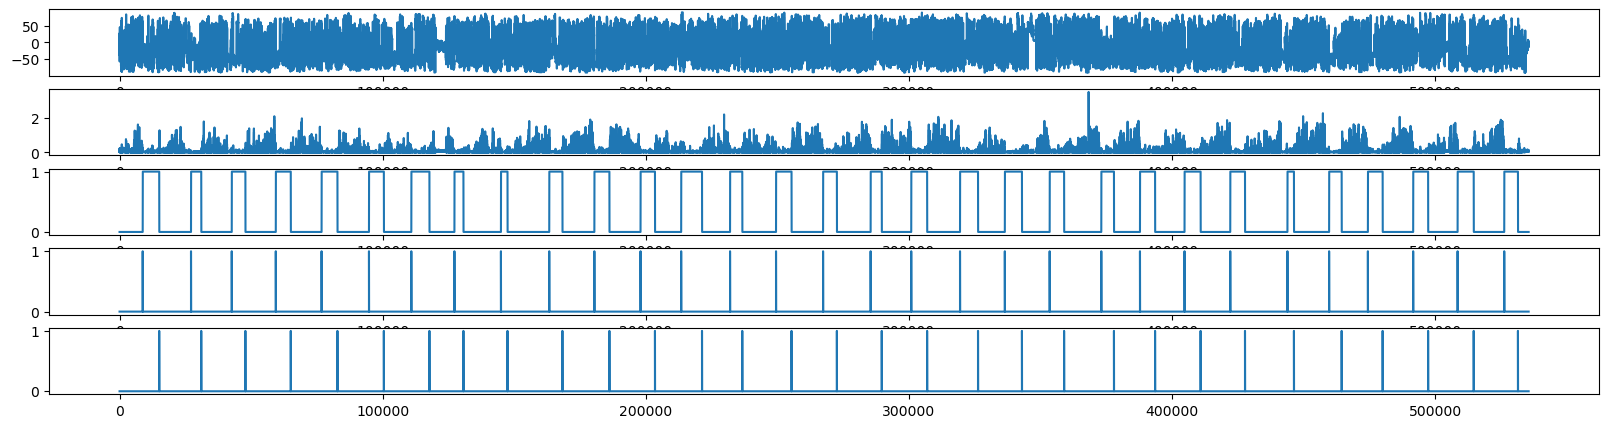

349c5562ee2c


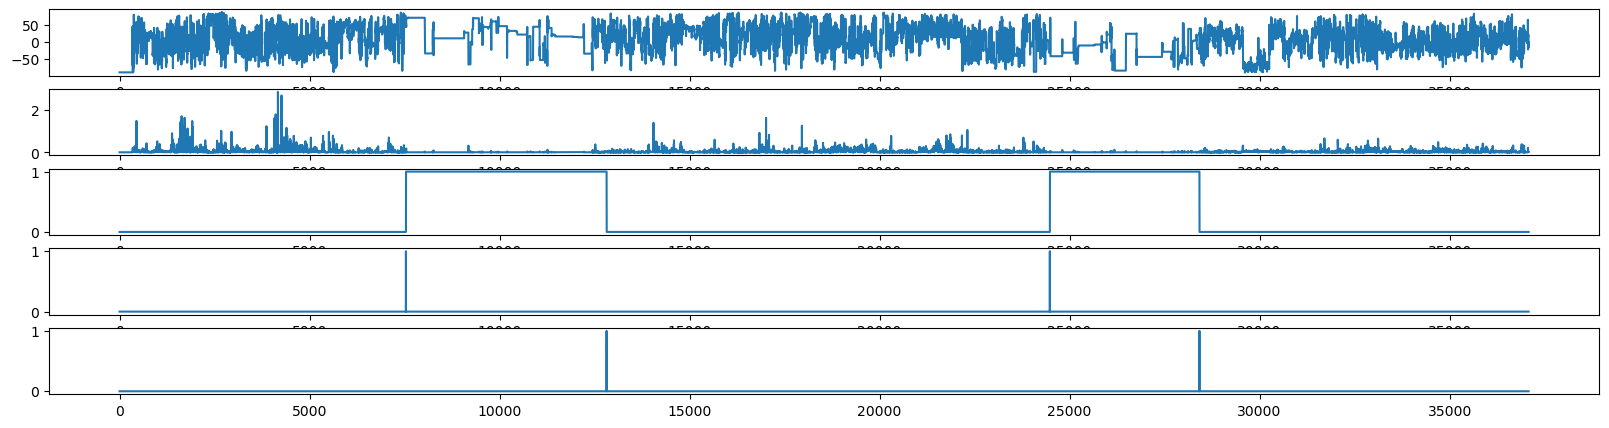

3664fe9233f9


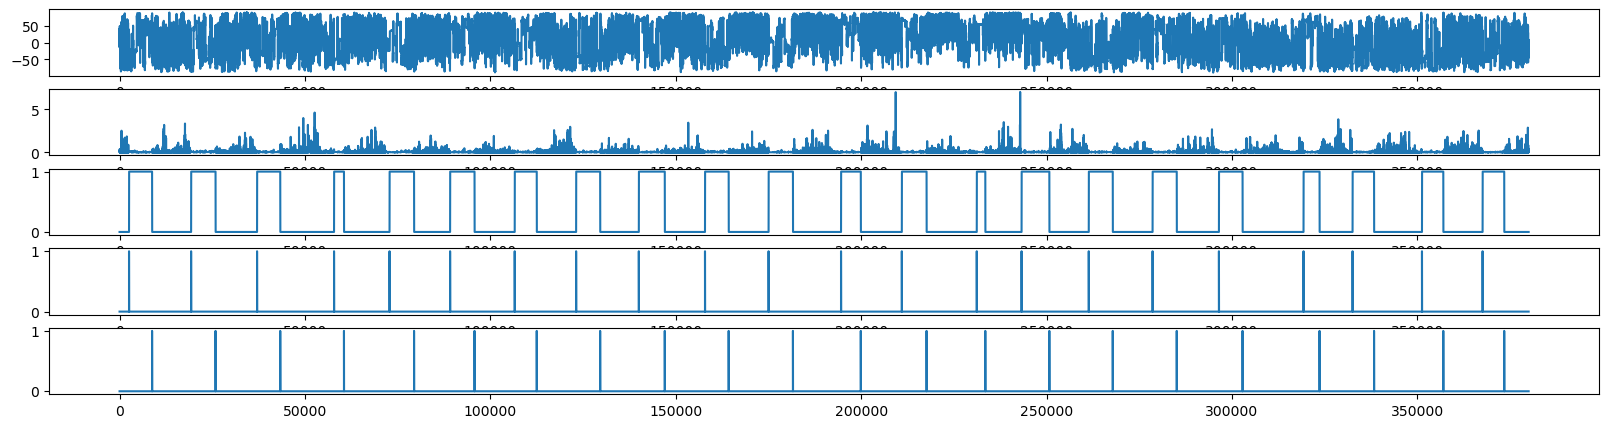

In [32]:
for idx, series in enumerate(train_series["series_id"].unique()):
    print(series)
    plt.figure(figsize=(20, 5))
    plt.subplot(5, 1, 1)
    plt.plot(train_series[train_series["series_id"] == series]["step"], train_series[train_series["series_id"] == series]["anglez"])
    plt.subplot(5, 1, 2)
    plt.plot(train_series[train_series["series_id"] == series]["step"], train_series[train_series["series_id"] == series]["enmo"])
    plt.subplot(5, 1, 3)
    plt.plot(train_series[train_series["series_id"] == series]["step"], train_series[train_series["series_id"] == series]["event"])
    plt.subplot(5, 1, 4)
    plt.plot(train_series[train_series["series_id"] == series]["step"], train_series[train_series["series_id"] == series]["event_onset"])
    plt.subplot(5, 1, 5)
    plt.plot(train_series[train_series["series_id"] == series]["step"], train_series[train_series["series_id"] == series]["event_wakeup"])
    plt.show()
    if idx == 10:
        break

In [33]:
train_series[train_series["series_id"] == "31011ade7c0a"]

,series_id,step,timestamp,anglez,enmo,event,event_onset,event_wakeup
2844900,31011ade7c0a,0,2017-08-15T16:45:00-0400,-82.680603,0.0000,0.0,0,0
2844901,31011ade7c0a,1,2017-08-15T16:45:05-0400,-82.680603,0.0000,0.0,0,0
2844902,31011ade7c0a,2,2017-08-15T16:45:10-0400,-82.680603,0.0000,0.0,0,0
2844903,31011ade7c0a,3,2017-08-15T16:45:15-0400,-82.680603,0.0000,0.0,0,0
2844904,31011ade7c0a,4,2017-08-15T16:45:20-0400,-82.680603,0.0000,0.0,0,0
...,...,...,...,...,...,...,...,...
3409735,31011ade7c0a,564835,2017-09-17T09:14:35-0400,-6.634300,0.0009,0.0,0,0
3409736,31011ade7c0a,564836,2017-09-17T09:14:40-0400,-4.754400,0.0014,0.0,0,0
3409737,31011ade7c0a,564837,2017-09-17T09:14:45-0400,-4.644000,0.0007,0.0,0,0
3409738,31011ade7c0a,564838,2017-09-17T09:14:50-0400,-3.622200,0.0006,0.0,0,0


In [ ]:
train_series.to_parquet(os.path.join(CFG.input_dir, "processed_train_nonull.parquet"), index=False)